<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19974 entries, 0 to 19973
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         19974 non-null  int64 
 1   full_name          19974 non-null  object
 2   selling_price      19974 non-null  object
 3   new_price          9564 non-null   object
 4   year               19974 non-null  int64 
 5   seller_type        19974 non-null  object
 6   km_driven          19974 non-null  object
 7   owner_type         19974 non-null  object
 8   fuel_type          19974 non-null  object
 9   transmission_type  19974 non-null  object
 10  mileage            19814 non-null  object
 11  engine             19864 non-null  object
 12  max_power          19637 non-null  object
 13  seats              19887 non-null  object
dtypes: int64(2), object(12)
memory usage: 2.1+ MB


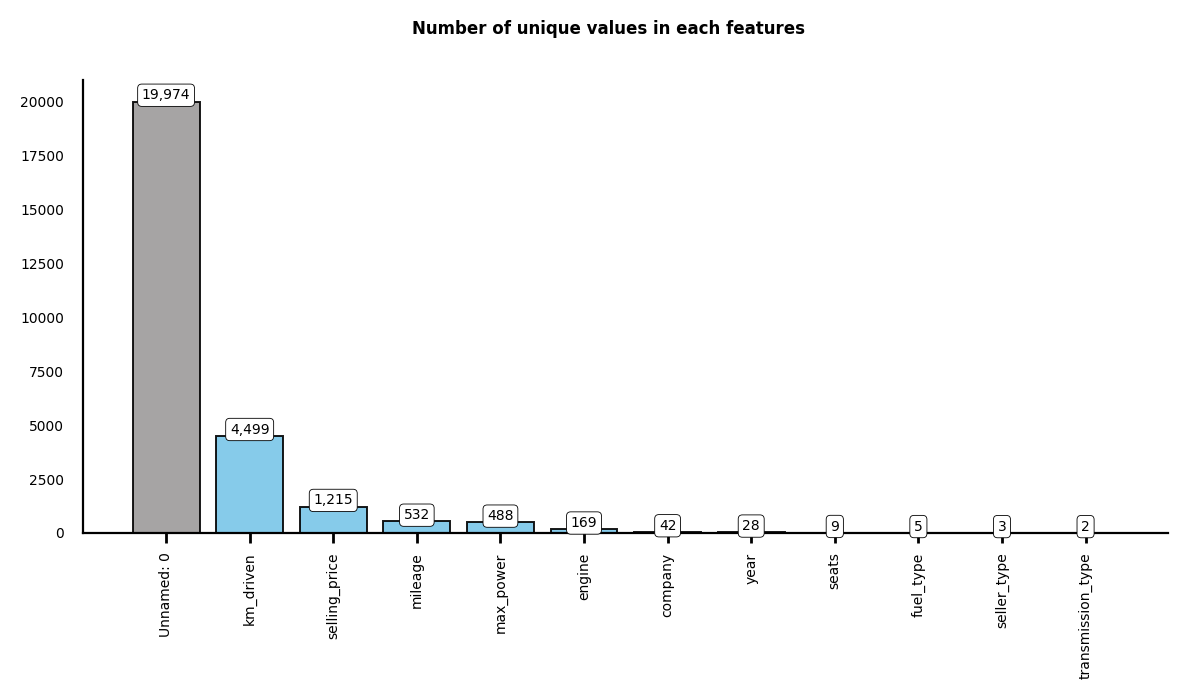

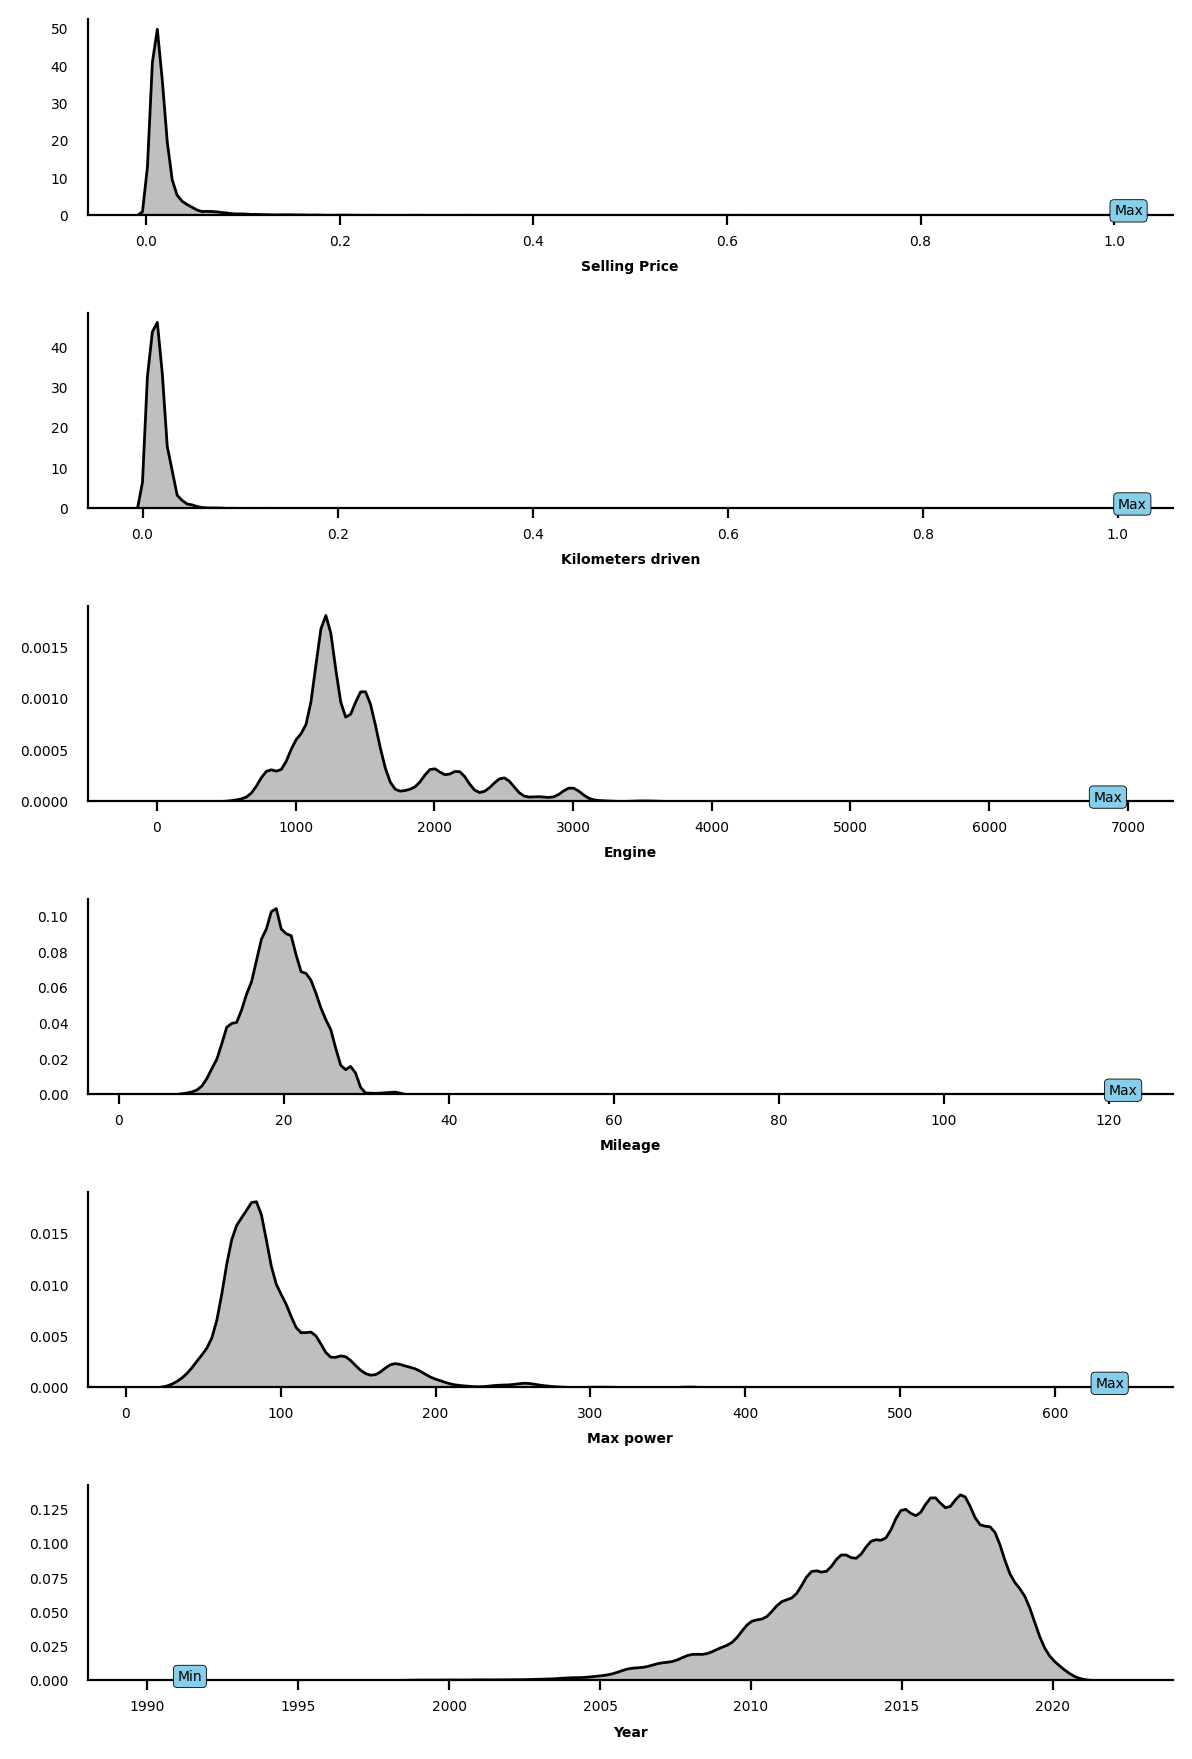

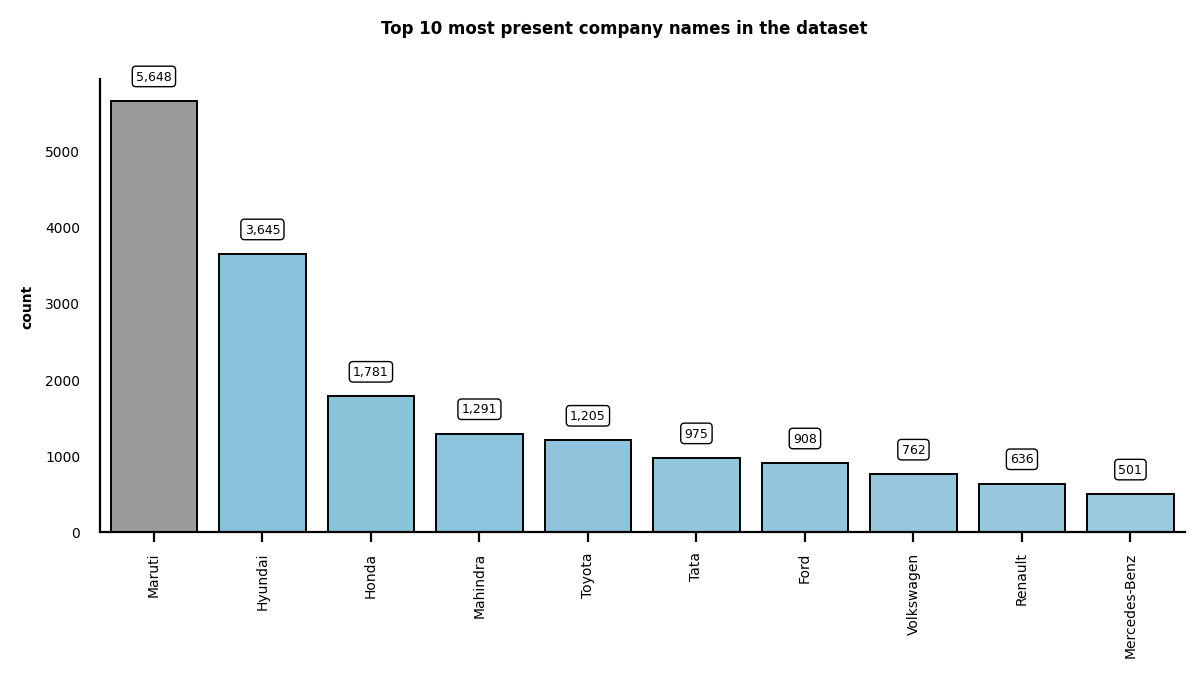

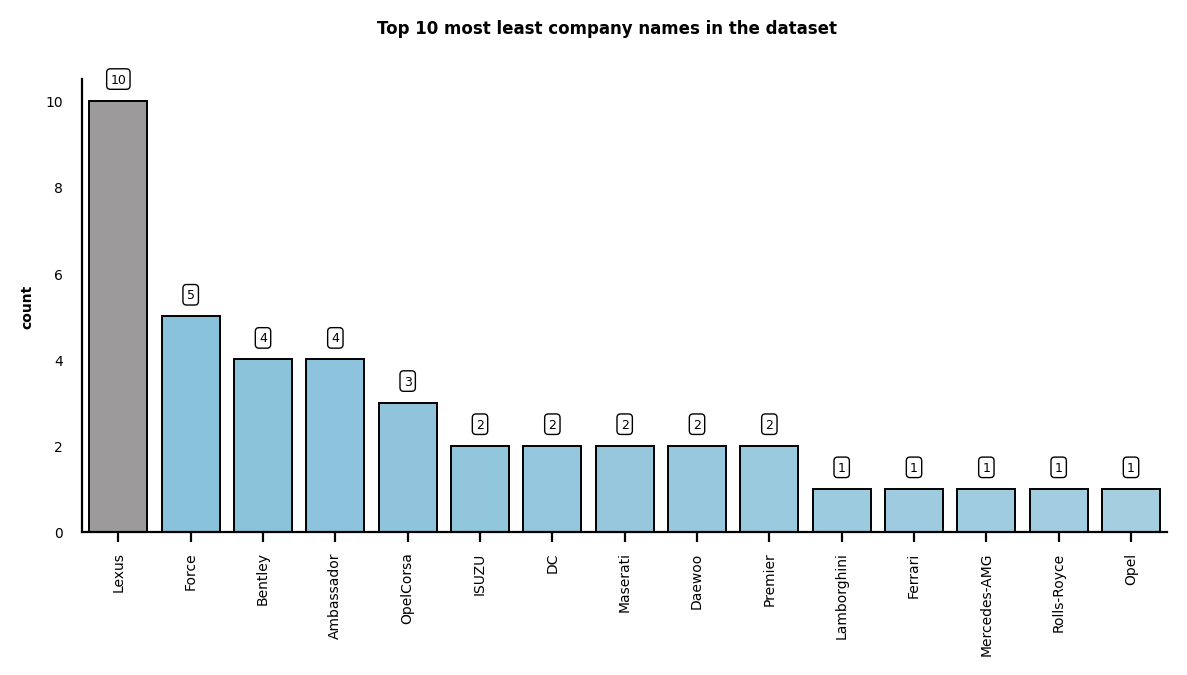

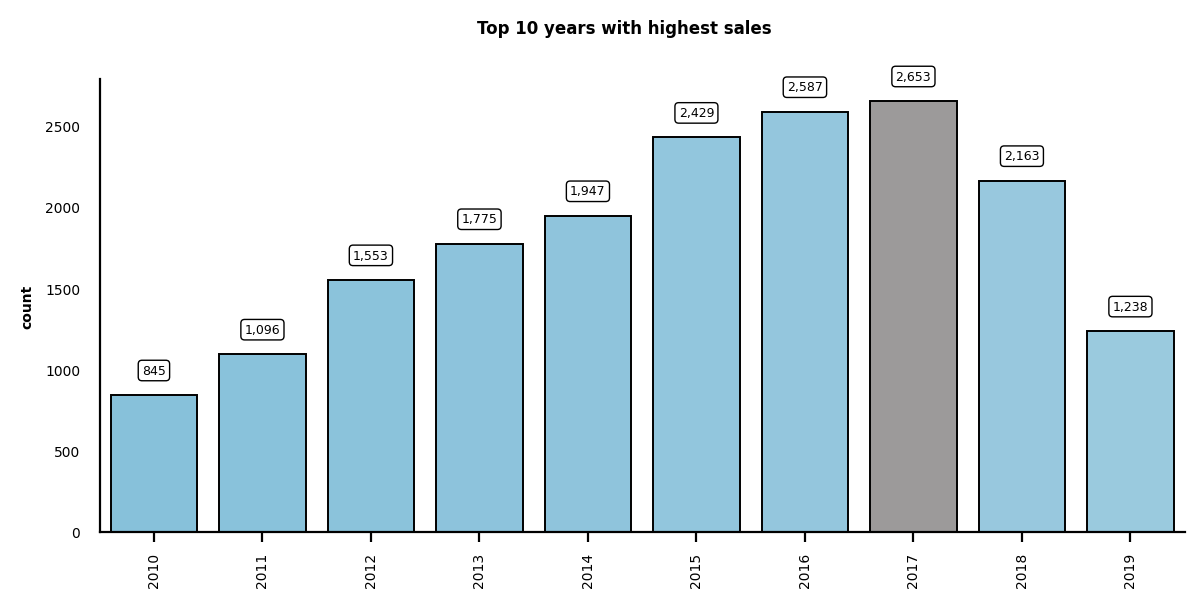

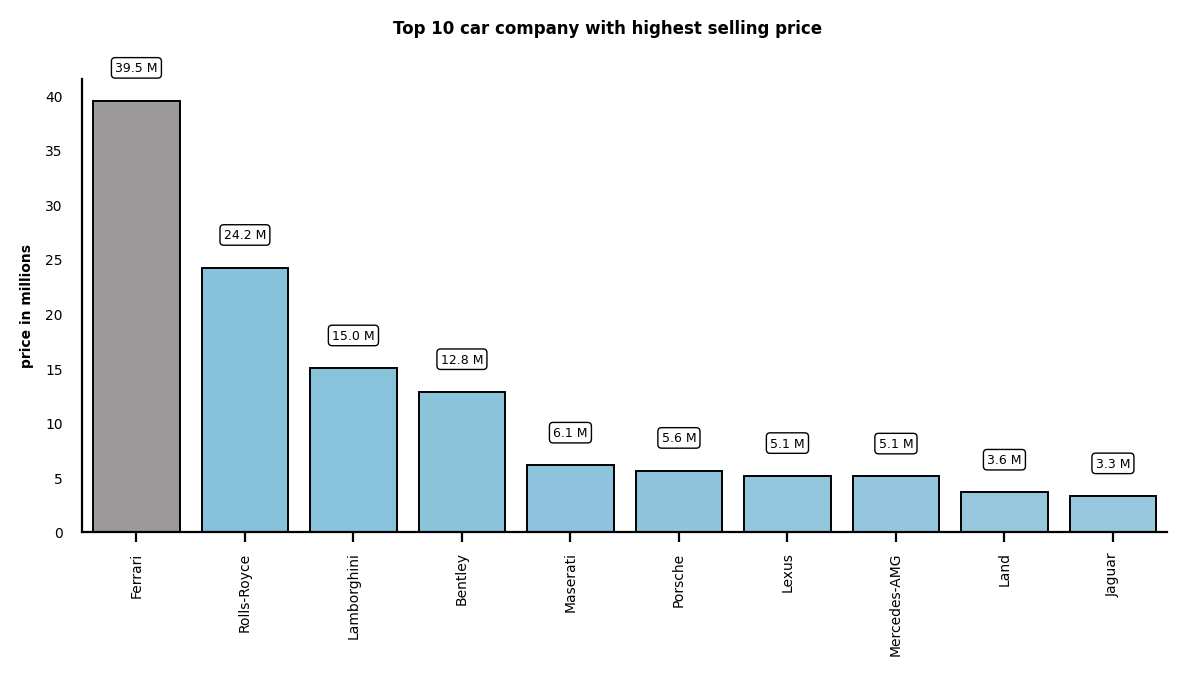

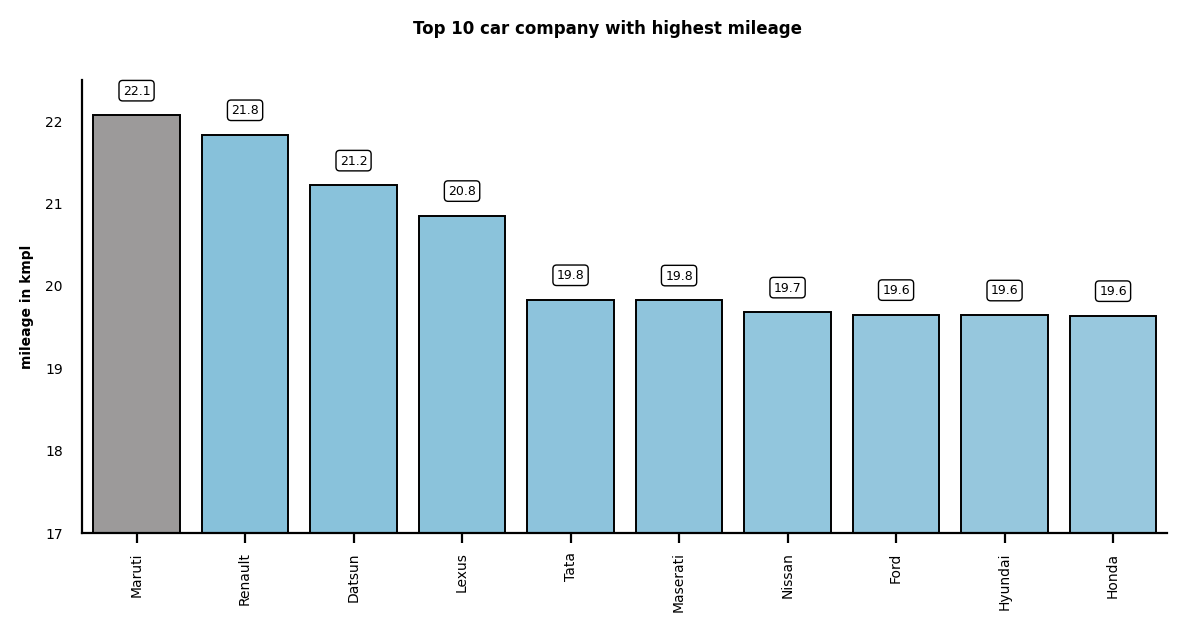

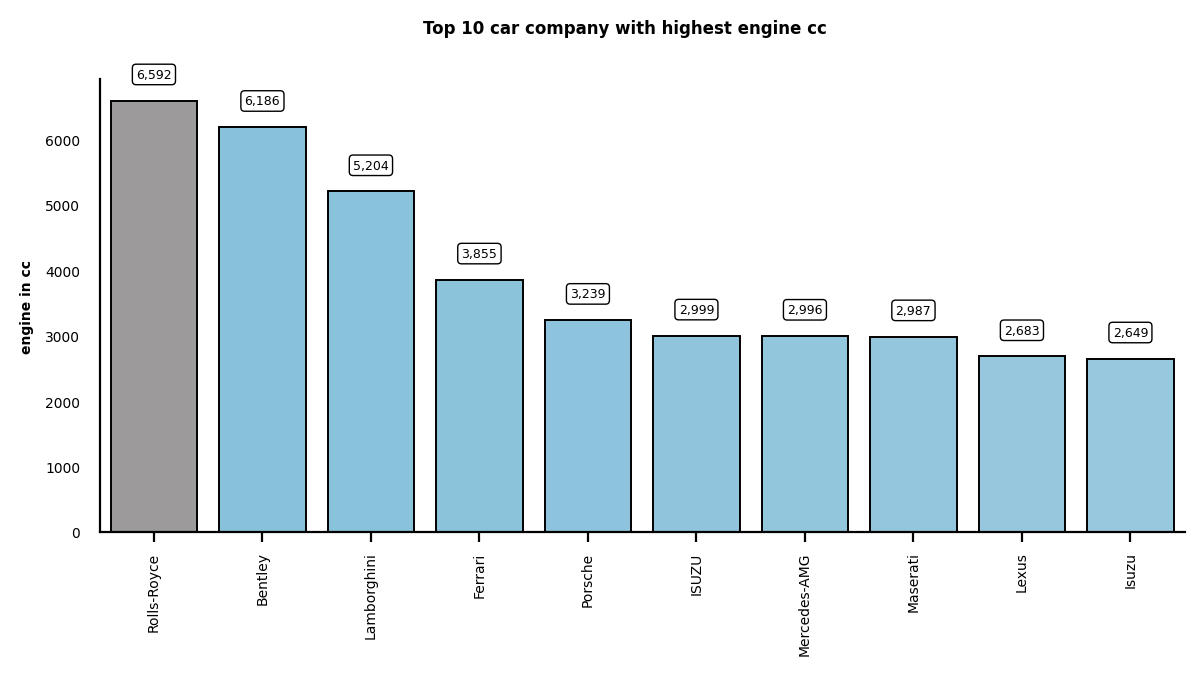

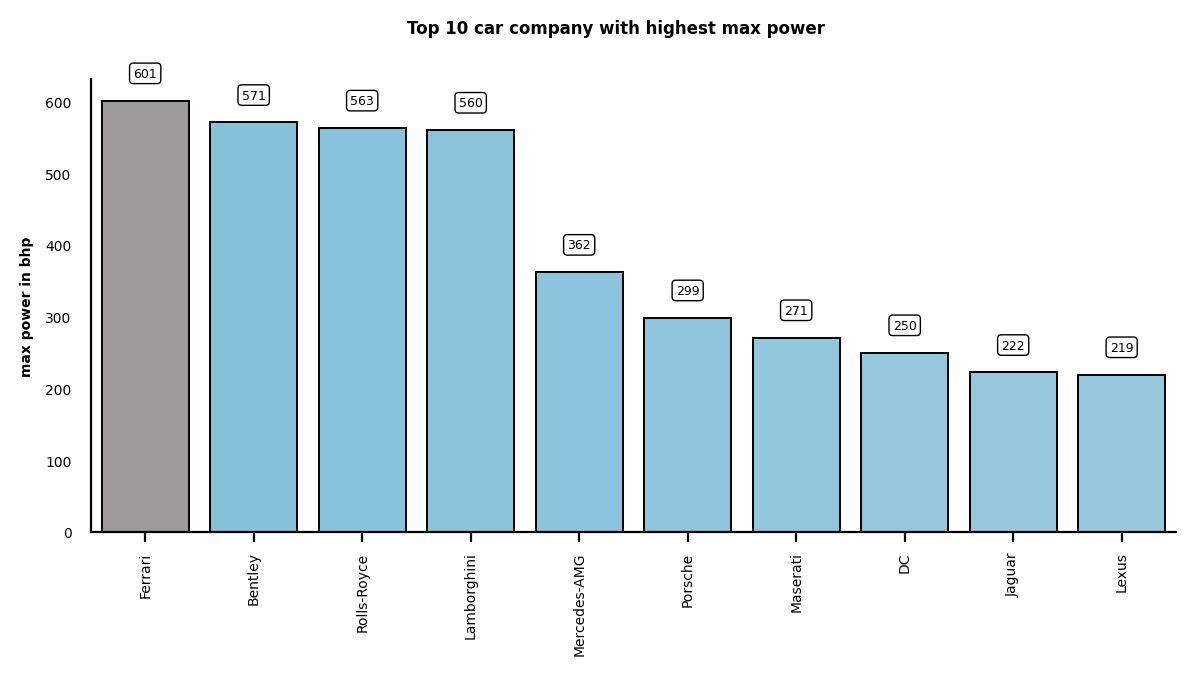

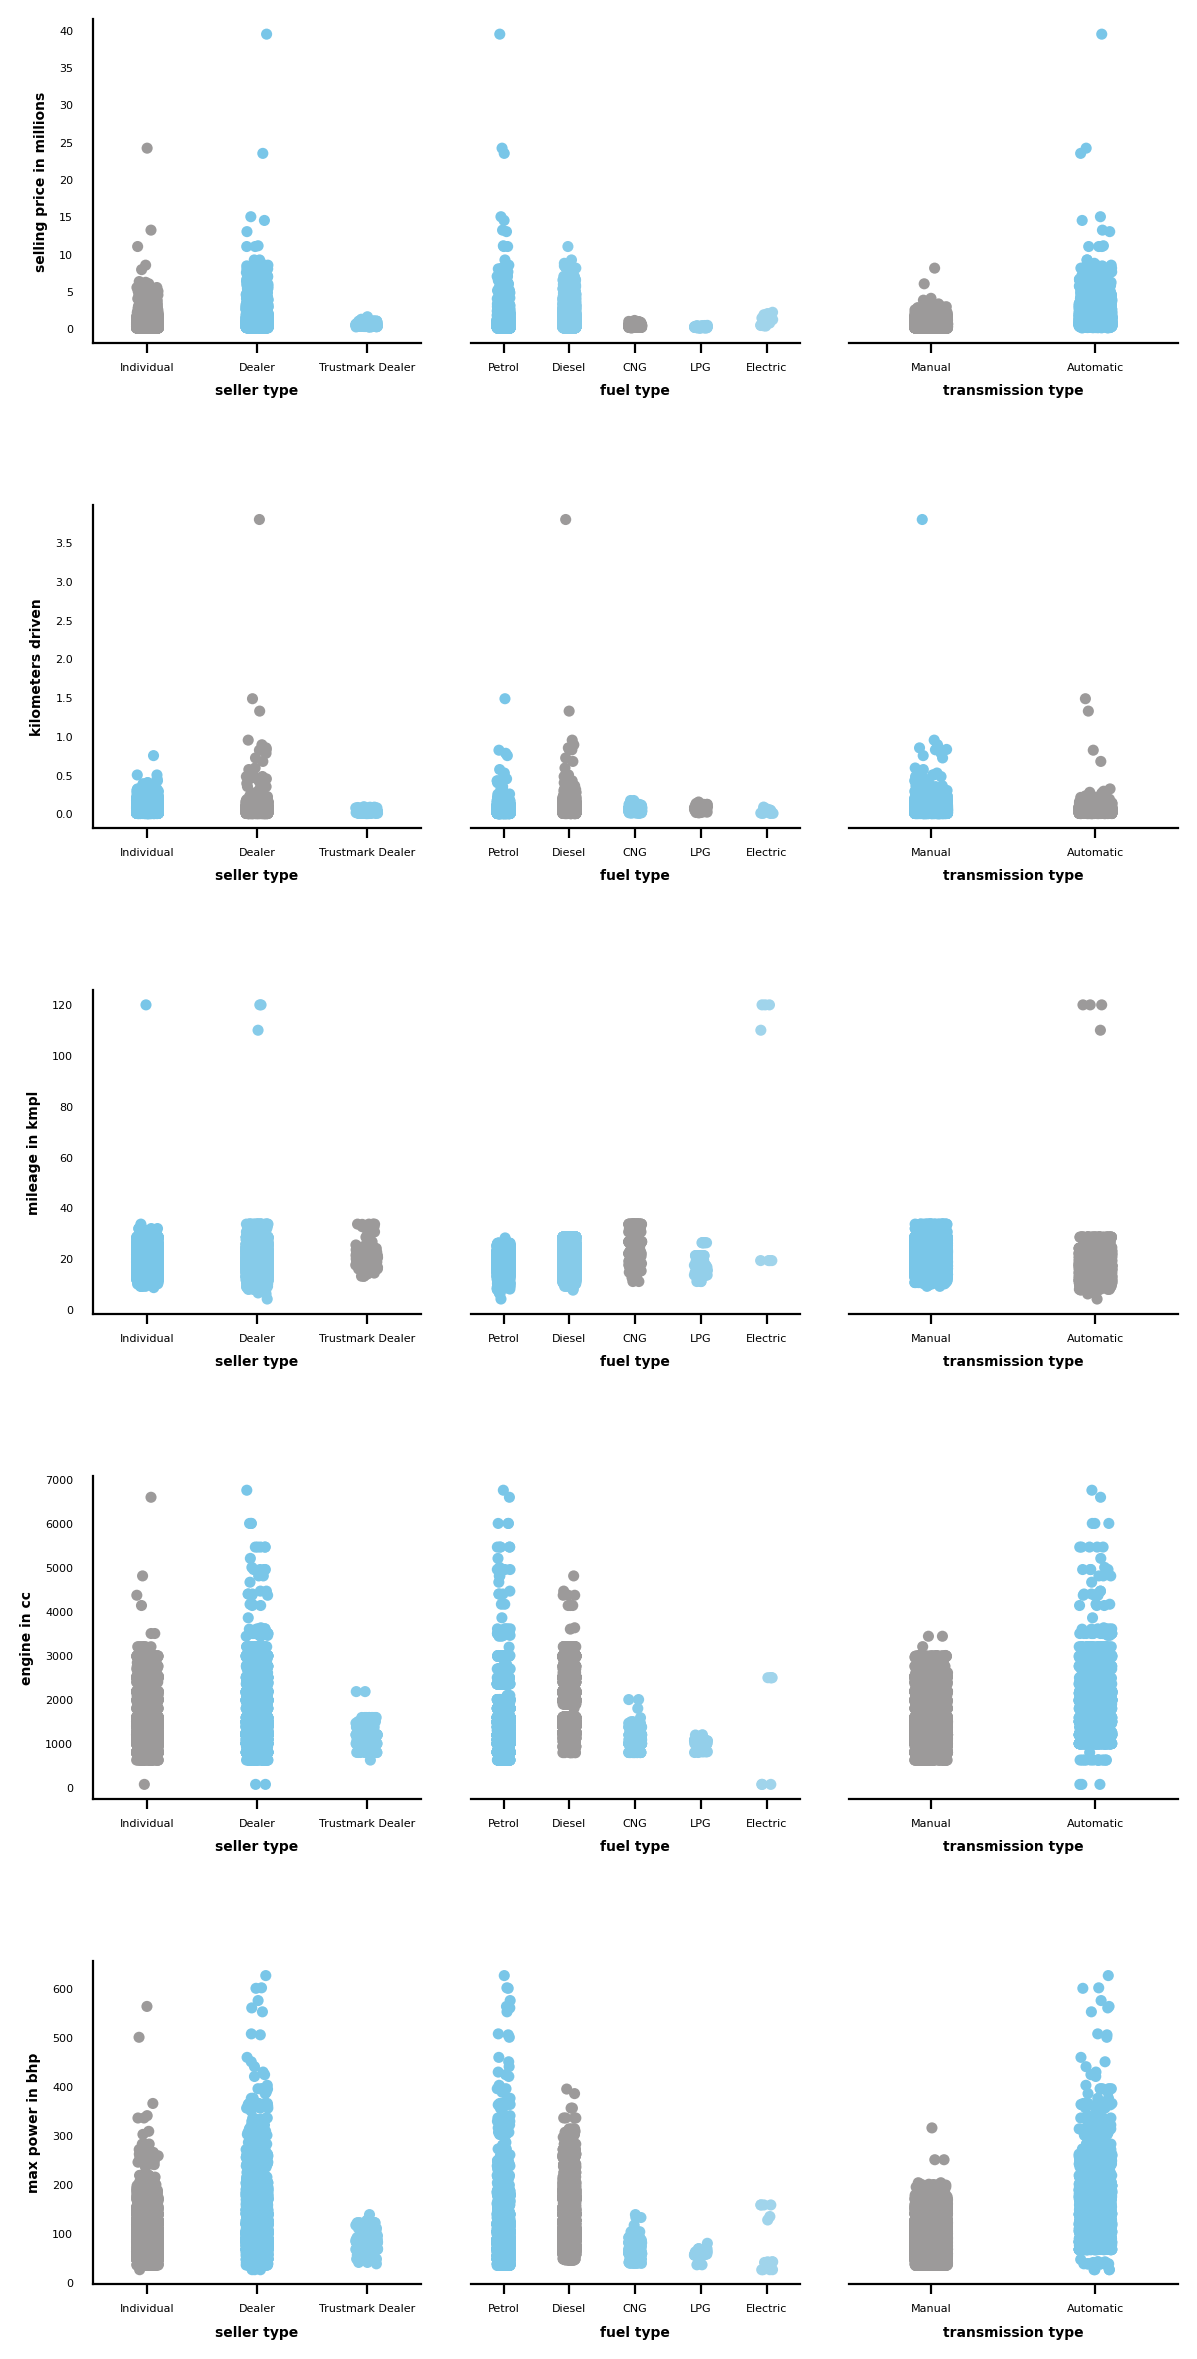

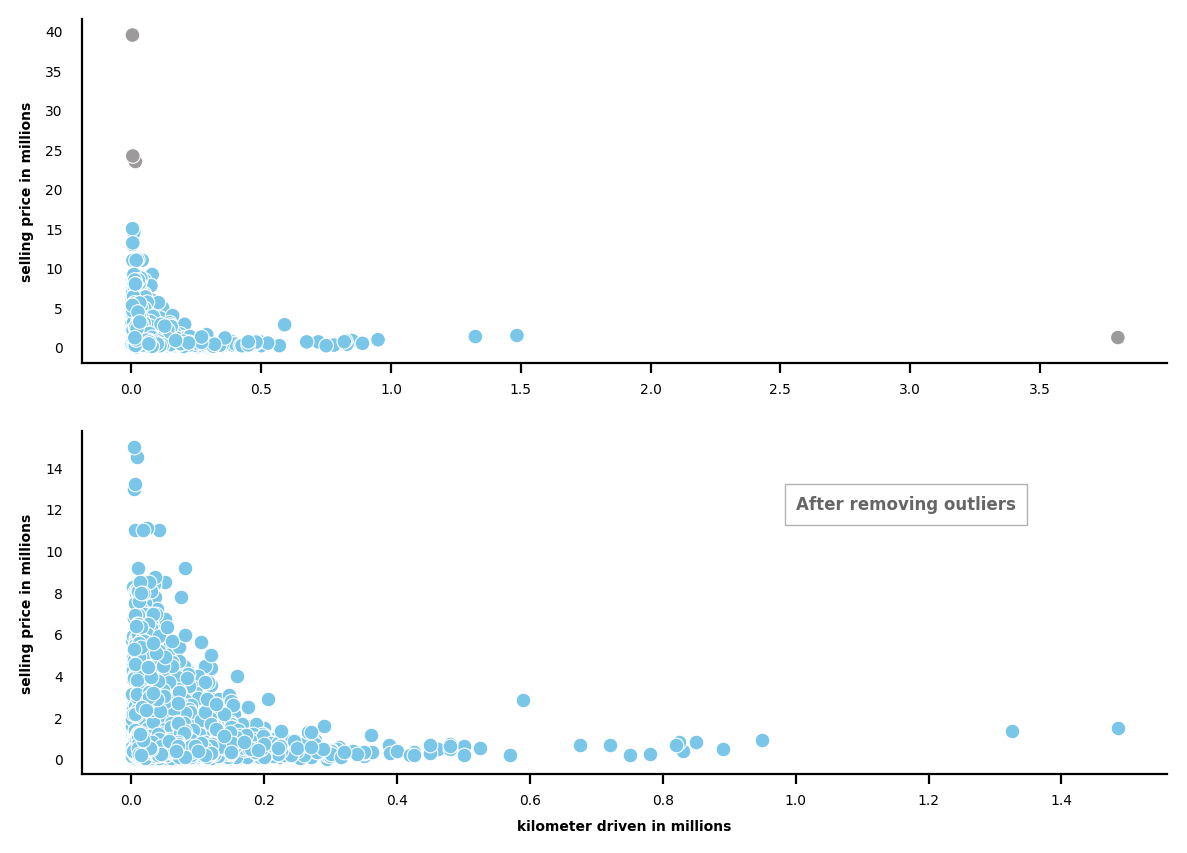

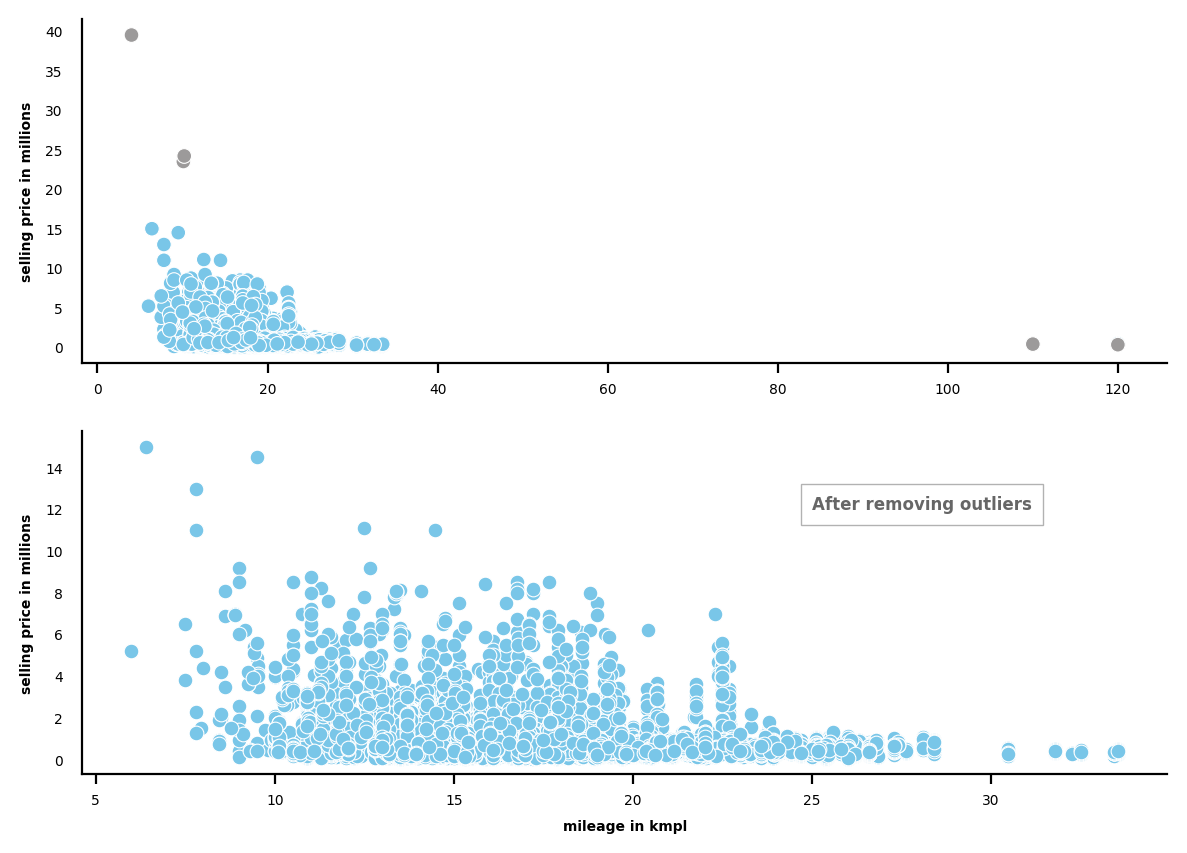

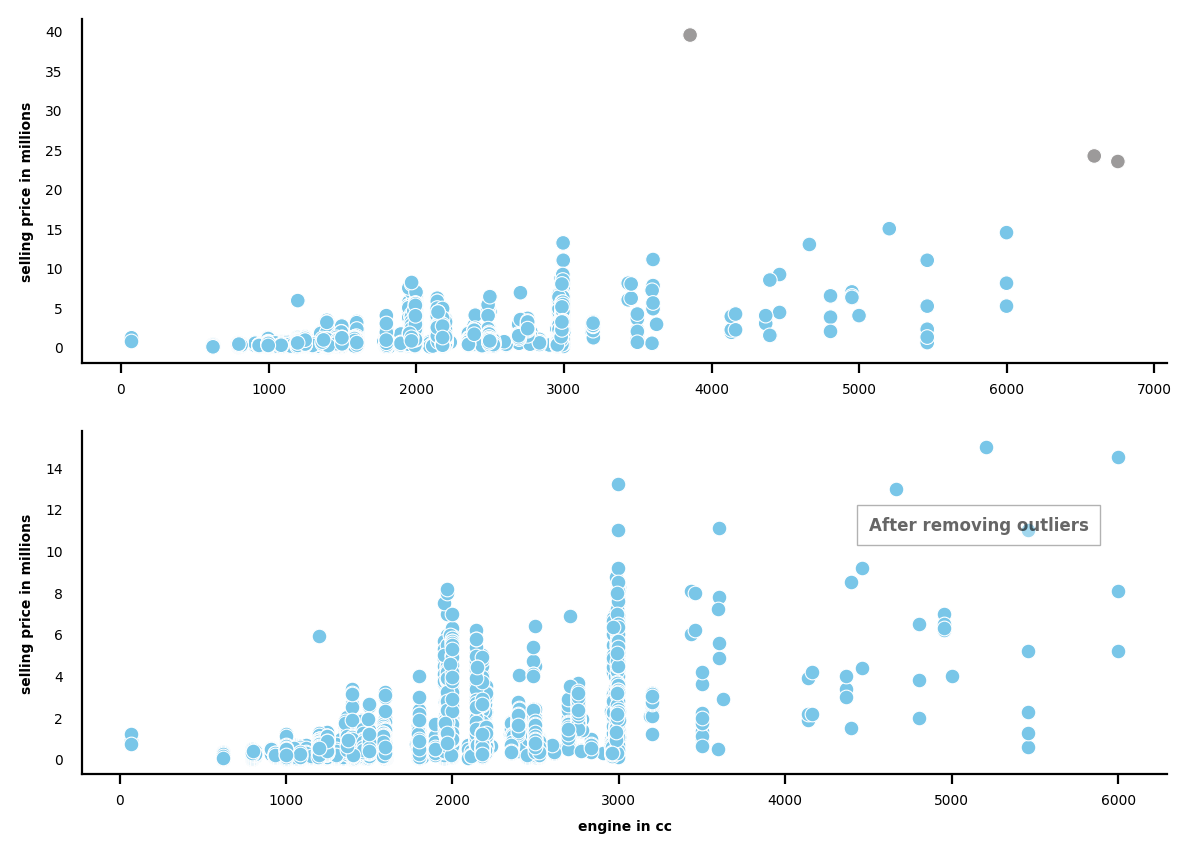

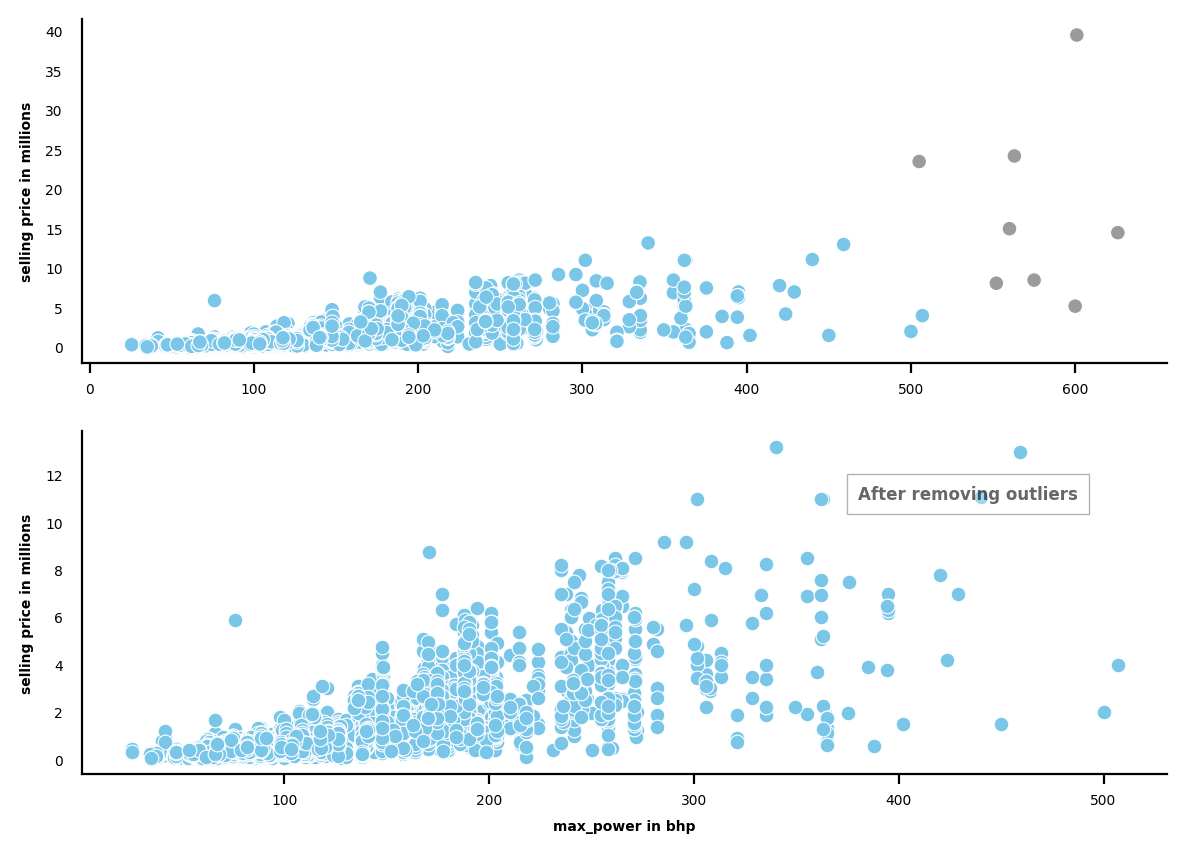

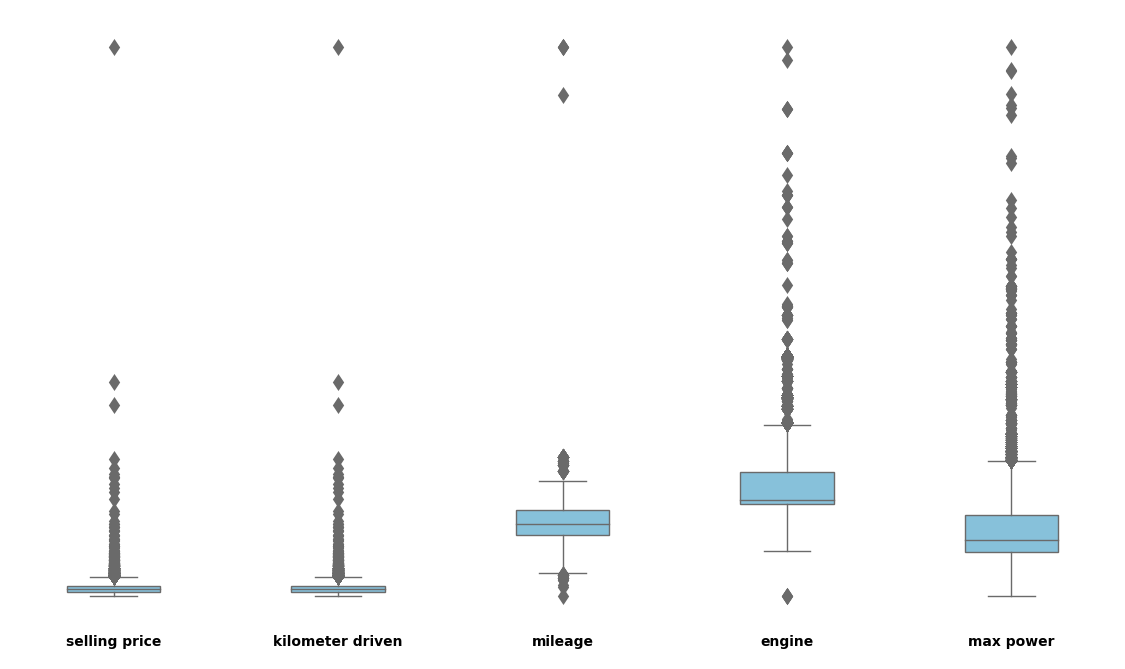

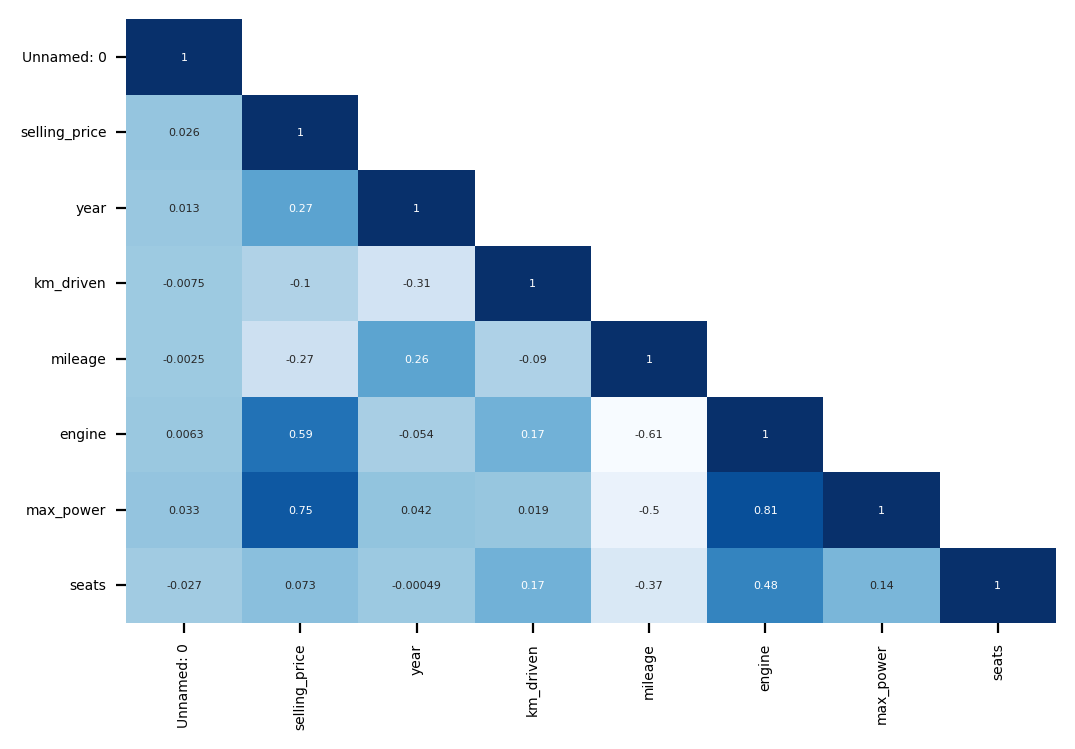

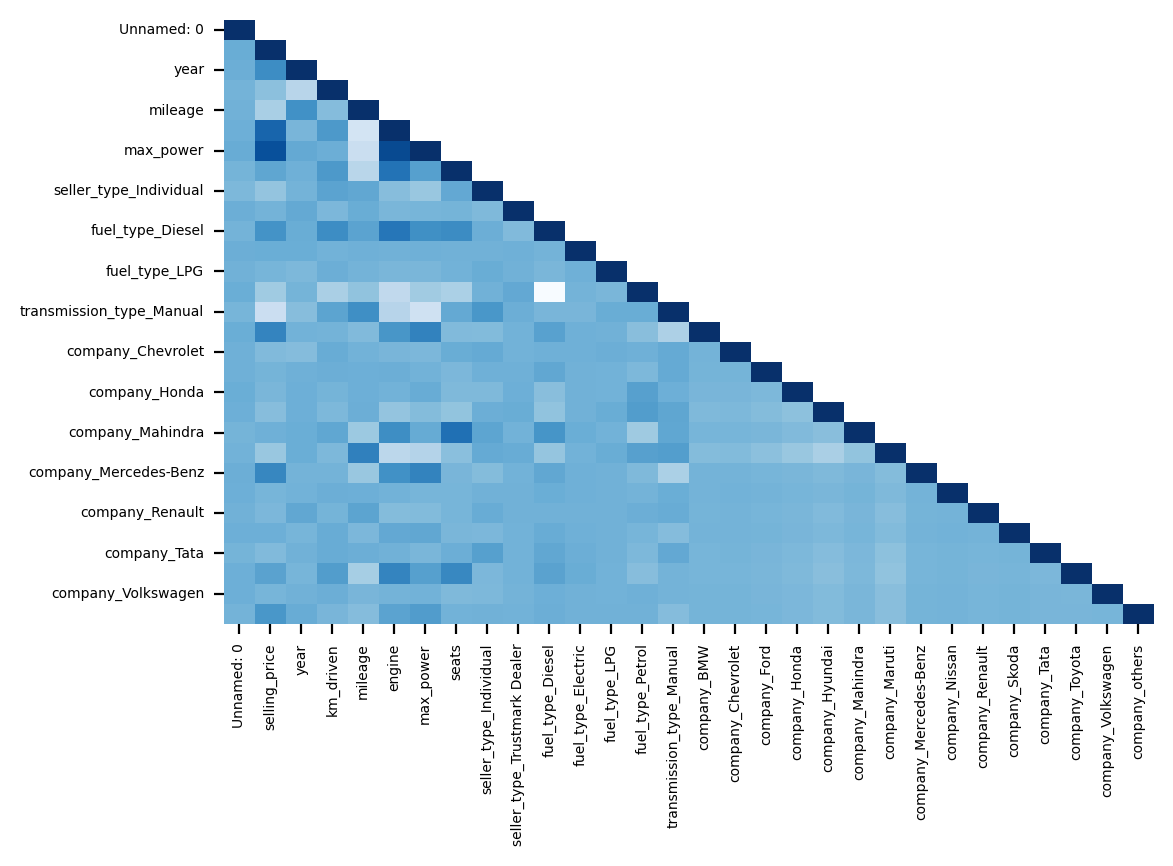

Linear Regression MAE: 235187.72
accuracy: 0.71
Decision Tree Regressor MAE: 124835.76
accuracy: 0.86
Random Forest Regressor MAE: 102127.9
accuracy: 0.92
Random Forest with hyperparameter tuning MAE: 99401.63
Accuracy: 0.92
283922.10858716135
Mean Squared Error: 80611763744.58
R-squared scores: 0.89
[6770590.]
       year  km_driven  mileage  engine  max_power  seats  \
0      2012     120000    19.70   796.0      46.30    5.0   
1      2016      20000    18.90  1197.0      82.00    5.0   
2      2010      60000    17.00  1197.0      80.00    5.0   
3      2012      37000    20.92   998.0      67.10    5.0   
4      2015      30000    22.77  1498.0      98.59    5.0   
...     ...        ...      ...     ...        ...    ...   
19954  2009      15000    19.00   998.0      66.10    5.0   
19955  2017      69480    23.59  1364.0      67.05    5.0   
19956  2019      18000    17.50  1373.0      91.10    7.0   
19957  2015      67000    21.14  1498.0     103.52    5.0   
19958  2019     

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error



import os
data = pd.read_csv('cardekho_updated.csv')
data.head()
data.shape
data.info()
def null_count():
    return pd.DataFrame({'features': data.columns,
                'dtypes': data.dtypes.values,
                'NaN count': data.isnull().sum().values,
                'NaN percentage': data.isnull().sum().values/data.shape[0]}).style.background_gradient(cmap='Blues',low=0.1,high=0.01)
null_count()
## Cleaning Data 
for i in range(data.shape[0]):
    try:
        price = float(data['selling_price'][i].split(' ')[0])
        digit = data['selling_price'][i].split(' ')[1]
        if digit == 'Lakh*':
            price = price * 100000
            data['selling_price'][i] = price
        elif digit == 'Cr*':
            price = price * 10000000
            data['selling_price'][i] = price
    except:
        price = data['selling_price'][i][:-1]
        price = price.replace(',', '')
        data['selling_price'][i] = float(price)
# kilometer driven
data['km_driven'] = data['km_driven'].str.split(' ', n=1, expand=True)[0]
data['km_driven'] = data['km_driven'].str.replace(',','')
# Mileage
data['mileage'] = data['mileage'].str.split(' ', expand=True)[0].str.split('e', expand=True)[2]
# Engine
data['engine'] = data['engine'].str.split(' ', expand=True)[0].str.split('e',expand=True)[1]
# Max Power
data['max_power'] = data['max_power'].str.split(' ', expand=True)[1].str.split('r',expand=True)[1]
# Seats 
data['seats'] = data['seats'].str.split('s', expand=True)[1]
#Changing the data types of the columns

cols = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']

for col in cols:
    try:
        data[col] = data[col].astype(int)
    except:
        data[col] = data[col].astype(float)
data.head()
# creating new feature company instead of full name
data['company'] = data['full_name'].str.split(' ', expand=True)[0]
#Droping unwanted columns
data.drop(columns=['new_price','full_name','owner_type'], axis=1, inplace=True)
data.head()
data.describe()
#Basic statistics on categorical features
data.describe(include='O')
x = data.nunique().sort_values(ascending=False).index
y = data.nunique().sort_values(ascending=False).values

plt.rcParams['figure.dpi'] = 200
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0,0])
for i in ['top', 'right']:
    ax0.spines[i].set_visible(False)
    
colormap = ['#79c6e8' for i in range(data.shape[1])]
colormap[0] = '#9c9a9a'

ax0.bar(x=x, height=y, edgecolor='k', linewidth=0.7, color=colormap, alpha=0.9)
ax0.tick_params(axis='x',labelsize=5, rotation=90, width=1)
ax0.tick_params(axis='y', labelsize=5, left=False)
fig.suptitle(t='Number of unique values in each features', fontsize=6, weight='bold')

for p in ax0.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()+290
    ax0.text(x, y, value, ha='center', va='center', fontsize=5, 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', linewidth=0.3))
plt.show()
#univariate in each features
plt.rcParams['figure.dpi'] = 200
fig = plt.figure(figsize=(7,11))
# fig.suptitle(t='Distribution of numerical features', fontsize=6, weight='bold')
gs = fig.add_gridspec(6,1)
gs.update(hspace=0.5)

mi=data.selling_price.min()
ma=data.selling_price.max()
price = (data.selling_price-mi)/(ma-mi)

ax0 = fig.add_subplot(gs[0,0])
ax0_sns = sns.kdeplot(x=price, shade=True, color='k')
ax0.text(x=price.max(), y=0, s='Max', fontsize=5, bbox=dict(facecolor='skyblue',linewidth=0.3,boxstyle='round'))
ax0_sns.tick_params(axis='both', labelsize=5, left=False)
ax0_sns.set_xlabel('Selling Price', fontsize=5, weight='bold')
ax0_sns.set_ylabel(None)

mi=data.km_driven.min()
ma=data.km_driven.max()
driven = (data.km_driven-mi)/(ma-mi)
ax1 = fig.add_subplot(gs[1,0])
ax1_sns = sns.kdeplot(x=driven, shade=True, color='k')
ax1.text(x=driven.max(), y=0, s='Max', fontsize=5, bbox=dict(facecolor='skyblue',linewidth=0.3,boxstyle='round'))
ax1_sns.tick_params(axis='both', labelsize=5, left=False)
ax1_sns.set_xlabel('Kilometers driven', fontsize=5, weight='bold')
ax1_sns.set_ylabel(None)

ax2 = fig.add_subplot(gs[2,0])
ax2_sns = sns.kdeplot(data=data,x='engine', shade=True, color='k')
ax2.text(x=data.engine.max(), y=0, s='Max', fontsize=5, bbox=dict(facecolor='skyblue',linewidth=0.3,boxstyle='round'))
ax2_sns.tick_params(axis='both', labelsize=5, left=False)
ax2_sns.set_xlabel('Engine', fontsize=5, weight='bold')
ax2_sns.set_ylabel(None)

ax3 = fig.add_subplot(gs[3,0])
ax3_sns = sns.kdeplot(data=data,x='mileage', shade=True, color='k')
ax3.text(x=data.mileage.max(), y=0, s='Max', fontsize=5, bbox=dict(facecolor='skyblue',linewidth=0.3,boxstyle='round'))
ax3_sns.tick_params(axis='both', labelsize=5, left=False)
ax3_sns.set_xlabel('Mileage', fontsize=5, weight='bold')
ax3_sns.set_ylabel(None)

ax4 = fig.add_subplot(gs[4,0])
ax4_sns = sns.kdeplot(data=data,x='max_power', shade=True, color='k')
ax4.text(x=data.max_power.max(), y=0, s='Max', fontsize=5, bbox=dict(facecolor='skyblue',linewidth=0.3,boxstyle='round'))
ax4_sns.tick_params(axis='both', labelsize=5, left=False)
ax4_sns.set_xlabel('Max power', fontsize=5, weight='bold')
ax4_sns.set_ylabel(None)

ax5 = fig.add_subplot(gs[5,0])
ax5_sns = sns.kdeplot(data=data,x='year', shade=True, color='k')
ax5.text(x=data.year.min(), y=0, s='Min', fontsize=5, bbox=dict(facecolor='skyblue',linewidth=0.3,boxstyle='round'))
ax5_sns.tick_params(axis='both', labelsize=5, left=False)
ax5_sns.set_xlabel('Year', fontsize=5, weight='bold')
ax5_sns.set_ylabel(None)

sns.despine()
plt.show()
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

cars = data.company.value_counts().head(10)
pal = sns.light_palette('#79c6e8', n_colors=50, reverse=True)
pal[0] = '#9c9a9a'
ax = fig.add_subplot(gs[0,0])
ax=sns.barplot(x=cars.index, y=cars.values, edgecolor='k', linewidth=0.7, palette=pal)
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=5, left=False)
ax.set_ylabel(ylabel='count', fontsize=5, weight='bold')

for p in ax.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()+320
    ax.text(x=x, y=y, s=value, fontsize=4.5, ha='center', va='center',
            bbox=dict(fc='white', edgecolor='k', boxstyle='round', linewidth=0.5))
    
fig.suptitle(t='Top 10 most present company names in the dataset', fontsize='6', weight='bold')
sns.despine()
plt.show()

fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

cars = data.company.value_counts().tail(15)
pal = sns.light_palette('#79c6e8', n_colors=50, reverse=True)
pal[0] = '#9c9a9a'
ax = fig.add_subplot(gs[0,0])
ax=sns.barplot(x=cars.index, y=cars.values, edgecolor='k', linewidth=0.7, palette=pal)
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=5, left=False)
ax.set_ylabel(ylabel='count', fontsize=5, weight='bold')

for p in ax.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()+0.5
    ax.text(x=x, y=y, s=value, fontsize=4.5, ha='center', va='center',
           bbox=dict(fc='white', edgecolor='k', boxstyle='round', linewidth=0.5))
    
fig.suptitle(t='Top 10 most least company names in the dataset', fontsize='6', weight='bold')
sns.despine()
plt.show()
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

cars = data.year.value_counts().head(10)
pal = sns.light_palette('#79c6e8', n_colors=50, reverse=True)
pal[7] = '#9c9a9a'
ax = fig.add_subplot(gs[0,0])
ax=sns.barplot(x=cars.index, y=cars.values, edgecolor='k', linewidth=0.7, palette=pal)
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=5, left=False)
ax.set_ylabel(ylabel='count', fontsize=5, weight='bold')

for p in ax.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()+150
    ax.text(x=x, y=y, s=value, fontsize=4.5, ha='center', va='center',
           bbox=dict(fc='white', edgecolor='k', boxstyle='round', linewidth=0.5))
    
fig.suptitle(t='Top 10 years with highest sales', fontsize='6', weight='bold')
sns.despine()
plt.show()
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

pal = sns.light_palette('#79c6e8', reverse=True, n_colors=50)
pal.insert(0,'#9c9a9a')

cars = data.groupby('company')['selling_price'].mean().sort_values(ascending=False).head(10)/1000000
ax = fig.add_subplot(gs[0,0])
ax=sns.barplot(x=cars.index, y=cars.values, edgecolor='k', linewidth=0.7, palette=pal)
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=5, left=False)
ax.set_xlabel(xlabel=None)
ax.set_ylabel(ylabel='price in millions', fontsize=5, weight='bold')
for p in ax.patches:
    value = f'{p.get_height():,.1f}' + ' M'
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()+3
    ax.text(x=x, y=y, s=value, fontsize=4.5, ha='center', va='center',
           bbox=dict(fc='white', edgecolor='k', boxstyle='round', linewidth=0.5))
    
fig.suptitle(t='Top 10 car company with highest selling price', fontsize=6, weight='bold')
sns.despine()
plt.show()
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

pal = sns.light_palette('#79c6e8', reverse=True, n_colors=50)
pal.insert(0,'#9c9a9a')

cars = data.groupby('company')['mileage'].mean().sort_values(ascending=False).head(10)
ax = fig.add_subplot(gs[0,0])
ax=sns.barplot(x=cars.index, y=cars.values, edgecolor='k', linewidth=0.7, palette=pal)
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=5, left=False)
ax.set_xlabel(xlabel=None)
ax.set_ylabel(ylabel='mileage in kmpl', fontsize=5, weight='bold')
ax.set_ylim(17,22.5)

for p in ax.patches:
    value = f'{p.get_height():,.1f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()+0.3
    ax.text(x=x, y=y, s=value, fontsize=4.5, ha='center', va='center',
           bbox=dict(fc='white', edgecolor='k', boxstyle='round', linewidth=0.5))
    
fig.suptitle(t='Top 10 car company with highest mileage', fontsize=6, weight='bold')
sns.despine()
plt.show()

fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

pal = sns.light_palette('#79c6e8', reverse=True, n_colors=50)
pal.insert(0,'#9c9a9a')

cars = data.groupby('company')['engine'].mean().sort_values(ascending=False).head(10)
ax = fig.add_subplot(gs[0,0])
ax=sns.barplot(x=cars.index, y=cars.values, edgecolor='k', linewidth=0.7, palette=pal)
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=5, left=False)
ax.set_xlabel(xlabel=None)
ax.set_ylabel(ylabel='engine in cc', fontsize=5, weight='bold')
for p in ax.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()+400
    ax.text(x=x, y=y, s=value, fontsize=4.5, ha='center', va='center',
           bbox=dict(fc='white', edgecolor='k', boxstyle='round', linewidth=0.5))
    
fig.suptitle(t='Top 10 car company with highest engine cc', fontsize=6, weight='bold')
sns.despine()
plt.show()
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

pal = sns.light_palette('#79c6e8', reverse=True, n_colors=50)
pal.insert(0,'#9c9a9a')

cars = data.groupby('company')['max_power'].mean().sort_values(ascending=False).head(10)
color = ['skyblue' for i in range(15)]
color[0] = 'grey'
ax = fig.add_subplot(gs[0,0])
ax=sns.barplot(x=cars.index, y=cars.values, edgecolor='k', linewidth=0.7, palette=pal)
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=5, left=False)
ax.set_xlabel(xlabel=None)
ax.set_ylabel(ylabel='max power in bhp', fontsize=5, weight='bold')
for p in ax.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_y() + p.get_height()+38
    ax.text(x=x, y=y, s=value, fontsize=4.5, ha='center', va='center',
           bbox=dict(fc='white', edgecolor='k', boxstyle='round', linewidth=0.5))
    
fig.suptitle(t='Top 10 car company with highest max power', fontsize=6, weight='bold')
sns.despine()
plt.show()
fig = plt.figure(figsize=(7,15))
gs = fig.add_gridspec(5,3)
gs.update(hspace=0.5, wspace=0.15)



# Row 1 selling_price-----------------------------------------------------------------
ax00 = fig.add_subplot(gs[0,0])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(0,'#9c9a9a')
ax00_s = sns.stripplot(x=data.seller_type, y=data.selling_price/1000000, size=4, palette=pal)
ax00_s.tick_params(labelsize=4, left=False)
ax00_s.set_xlabel(xlabel='seller type', fontsize=5, weight='bold')
ax00_s.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')
for i in ['top', 'right']:
    ax00.spines[i].set_visible(False)

ax01 = fig.add_subplot(gs[0,1])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(2,'#9c9a9a')
ax01_s = sns.stripplot(x=data.fuel_type, y=data.selling_price/1000000, size=4, palette=pal)
ax01_s.tick_params(labelsize=4, left=False)
ax01_s.set_xlabel(xlabel='fuel type', fontsize=5, weight='bold')
ax01_s.set_ylabel(ylabel=None)
ax01_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax01.spines[i].set_visible(False)

ax02 = fig.add_subplot(gs[0,2])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(0,'#9c9a9a')
ax02_s = sns.stripplot(x=data.transmission_type, y=data.selling_price/1000000, size=4, palette=pal)
ax02_s.tick_params(labelsize=4, left=False)
ax02_s.set_xlabel(xlabel='transmission type', fontsize=5, weight='bold')
ax02_s.set_ylabel(ylabel=None)
ax02_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax02.spines[i].set_visible(False)

# Row 2 km_driven-------------------------------------------------------------------------
ax10 = fig.add_subplot(gs[1,0])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(1,'#9c9a9a')
ax10_s = sns.stripplot(x=data.seller_type, y=data.km_driven/1000000, size=4, palette=pal)
ax10_s.tick_params(labelsize=4, left=False)
ax10_s.set_xlabel(xlabel='seller type', fontsize=5, weight='bold')
ax10_s.set_ylabel(ylabel='kilometers driven', fontsize=5, weight='bold')
for i in ['top', 'right']:
    ax10.spines[i].set_visible(False)

ax11 = fig.add_subplot(gs[1,1])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(1,'#9c9a9a')
pal.insert(3,'#9c9a9a')
ax11_s = sns.stripplot(x=data.fuel_type, y=data.km_driven/1000000, size=4, palette=pal)
ax11_s.tick_params(labelsize=4, left=False)
ax11_s.set_xlabel(xlabel='fuel type', fontsize=5, weight='bold')
ax11_s.set_ylabel(ylabel=None)
ax11_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax11.spines[i].set_visible(False)

ax12 = fig.add_subplot(gs[1,2])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(1,'#9c9a9a')
ax12_s = sns.stripplot(x=data.transmission_type, y=data.km_driven/1000000, size=4, palette=pal)
ax12_s.tick_params(labelsize=4, left=False)
ax12_s.set_xlabel(xlabel='transmission type', fontsize=5, weight='bold')
ax12_s.set_ylabel(ylabel=None)
ax12_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax12.spines[i].set_visible(False)

# Row 3 mileage---------------------------------------------------------------------------
ax20 = fig.add_subplot(gs[2,0])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(2,'#9c9a9a')
ax20_s = sns.stripplot(x=data.seller_type, y=data.mileage, size=4, palette=pal)
ax20_s.tick_params(labelsize=4, left=False)
ax20_s.set_xlabel(xlabel='seller type', fontsize=5, weight='bold')
ax20_s.set_ylabel(ylabel='mileage in kmpl', fontsize=5, weight='bold')
for i in ['top', 'right']:
    ax20.spines[i].set_visible(False)

ax21 = fig.add_subplot(gs[2,1])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(2,'#9c9a9a')
ax21_s = sns.stripplot(x=data.fuel_type, y=data.mileage, size=4, palette=pal)
ax21_s.tick_params(labelsize=4, left=False)
ax21_s.set_xlabel(xlabel='fuel type', fontsize=5, weight='bold')
ax21_s.set_ylabel(ylabel=None)
ax21_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax21.spines[i].set_visible(False)

ax22 = fig.add_subplot(gs[2,2])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(1,'#9c9a9a')
ax22_s = sns.stripplot(x=data.transmission_type, y=data.mileage, size=4, palette=pal)
ax22_s.tick_params(labelsize=4, left=False)
ax22_s.set_xlabel(xlabel='transmission type', fontsize=5, weight='bold')
ax22_s.set_ylabel(ylabel=None)
ax22_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax22.spines[i].set_visible(False)
    # Row 4 Engine------------------------------------------------------------------------------
ax30 = fig.add_subplot(gs[3,0])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(0,'#9c9a9a')
ax30_s = sns.stripplot(x=data.seller_type, y=data.engine, size=4, palette=pal)
ax30_s.tick_params(labelsize=4, left=False)
ax30_s.set_xlabel(xlabel='seller type', fontsize=5, weight='bold')
ax30_s.set_ylabel(ylabel='engine in cc', fontsize=5, weight='bold')
for i in ['top', 'right']:
    ax30.spines[i].set_visible(False)

ax31 = fig.add_subplot(gs[3,1])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(1,'#9c9a9a')
ax31_s = sns.stripplot(x=data.fuel_type, y=data.engine, size=4, palette=pal)
ax31_s.tick_params(labelsize=4, left=False)
ax31_s.set_xlabel(xlabel='fuel type', fontsize=5, weight='bold')
ax31_s.set_ylabel(ylabel=None)
ax31_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax31.spines[i].set_visible(False)

ax32 = fig.add_subplot(gs[3,2])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(0,'#9c9a9a')
ax32_s = sns.stripplot(x=data.transmission_type, y=data.engine, size=4, palette=pal)
ax32_s.tick_params(labelsize=4, left=False)
ax32_s.set_xlabel(xlabel='transmission type', fontsize=5, weight='bold')
ax32_s.set_ylabel(ylabel=None)
ax32_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax32.spines[i].set_visible(False)

# Row 5 max power------------------------------------------------------------------------------
ax40 = fig.add_subplot(gs[4,0])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(0,'#9c9a9a')
ax40_s = sns.stripplot(x=data.seller_type, y=data.max_power, size=4, palette=pal)
ax40_s.tick_params(labelsize=4, left=False)
ax40_s.set_xlabel(xlabel='seller type', fontsize=5, weight='bold')
ax40_s.set_ylabel(ylabel='max power in bhp', fontsize=5, weight='bold')
for i in ['top', 'right']:
    ax40.spines[i].set_visible(False)

ax41 = fig.add_subplot(gs[4,1])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(1,'#9c9a9a')
ax41_s = sns.stripplot(x=data.fuel_type, y=data.max_power, size=4, palette=pal)
ax41_s.tick_params(labelsize=4, left=False)
ax41_s.set_xlabel(xlabel='fuel type', fontsize=5, weight='bold')
ax41_s.set_ylabel(ylabel=None)
ax41_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax41.spines[i].set_visible(False)

ax42 = fig.add_subplot(gs[4,2])
pal = sns.light_palette('#79c6e8', reverse=True, n_colors=10)
pal.insert(0,'#9c9a9a')
ax42_s = sns.stripplot(x=data.transmission_type, y=data.max_power, size=4, palette=pal)
ax42_s.tick_params(labelsize=4, left=False)
ax42_s.set_xlabel(xlabel='transmission type', fontsize=5, weight='bold')
ax42_s.set_ylabel(ylabel=None)
ax42_s.set_yticks([])
for i in ['top', 'right', 'left']:
    ax42.spines[i].set_visible(False)

plt.show()
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)
color = ['#79c6e8' for i in range(data.shape[0])]
color[4967] = color[19972] = color[14257] = color[475] = '#9c9a9a'
ax=fig.add_subplot(gs[0,0])
ax.scatter(x=data.km_driven/1000000,y=data.selling_price/1000000,s=28,
                       color=color, edgecolor='white', linewidth=0.4)
ax.tick_params(labelsize=5, left=False)
ax.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')

ax1=fig.add_subplot(gs[1,0])
rmd_data = data[data['selling_price']<20000000]
rmd_data = rmd_data[rmd_data['km_driven']<2000000]
ax1.scatter(x=rmd_data.km_driven/1000000,y=rmd_data.selling_price/1000000,
            s=28, color='#79c6e8', edgecolor='white', linewidth=0.4)
ax1.tick_params(labelsize=5, left=False)
ax1.set_xlabel(xlabel='kilometer driven in millions', fontsize=5, weight='bold')
ax1.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')
ax1.text(x=1, y=12, s='After removing outliers', fontsize=6, weight='bold', alpha=0.6,
        bbox=dict(facecolor='white', lw=0.5, alpha=0.3))
sns.despine()
plt.show()
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)
color = ['#79c6e8' for i in range(data.shape[0])]
color[4967] = color[14257] = color[475] = color[11964] = color[18396]= '#9c9a9a'
ax=fig.add_subplot(gs[0,0])
ax.scatter(x=data.mileage,y=data.selling_price/1000000,s=28,
                       color=color, edgecolor='white', linewidth=0.4)
ax.tick_params(labelsize=5, left=False)
ax.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')

ax1=fig.add_subplot(gs[1,0])
rmd_data = data[data['selling_price']<20000000]
rmd_data = rmd_data[rmd_data['mileage']<100]
ax1.scatter(x=rmd_data.mileage,y=rmd_data.selling_price/1000000,s=28,
                       color='#79c6e8', edgecolor='white', linewidth=0.4)
ax1.tick_params(labelsize=5, left=False)
ax1.set_xlabel(xlabel='mileage in kmpl', fontsize=5, weight='bold')
ax1.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')
ax1.text(x=25, y=12, s='After removing outliers', fontsize=6, weight='bold', alpha=0.6,
        bbox=dict(facecolor='white', lw=0.5, alpha=0.3))
sns.despine()
plt.show()
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)
color = ['#79c6e8' for i in range(data.shape[0])]
color[4967] = color[475] = color[14257] = '#9c9a9a'
ax=fig.add_subplot(gs[0,0])
ax.scatter(x=data.engine,y=data.selling_price/1000000,s=28,
                       color=color, edgecolor='white', linewidth=0.4)
ax.tick_params(labelsize=5, left=False)
ax.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')

ax1=fig.add_subplot(gs[1,0])
rmd_data = data[data['selling_price']<20000000]
rmd_data = rmd_data[rmd_data['engine']<6100]
ax1.scatter(x=rmd_data.engine,y=rmd_data.selling_price/1000000,s=28,
                       color='#79c6e8', edgecolor='white', linewidth=0.4)
ax1.tick_params(labelsize=5, left=False)
ax1.set_xlabel(xlabel='engine in cc', fontsize=5, weight='bold')
ax1.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')
ax1.text(x=4500, y=11, s='After removing outliers', fontsize=6, weight='bold', alpha=0.6,
        bbox=dict(facecolor='white', lw=0.5, alpha=0.3))
sns.despine()
plt.show()

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)
color = ['#79c6e8' for i in range(data.shape[0])]
color[4967]=color[475]=color[14257]=color[1536]=color[17020]=color[16856]=color[13130]=color[3980]='#9c9a9a'
ax=fig.add_subplot(gs[0,0])
ax.scatter(x=data.max_power,y=data.selling_price/1000000,s=28,
                       color=color, edgecolor='white', linewidth=0.4)
ax.tick_params(labelsize=5, left=False)
ax.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')

ax1=fig.add_subplot(gs[1,0])
rmd_data = data[data['selling_price']<20000000]
rmd_data = rmd_data[rmd_data['max_power']<530]
ax1.scatter(x=rmd_data.max_power,y=rmd_data.selling_price/1000000,s=28,
                       color='#79c6e8', edgecolor='white', linewidth=0.4)
ax1.tick_params(labelsize=5, left=False)
ax1.set_xlabel(xlabel='max_power in bhp', fontsize=5, weight='bold')
ax1.set_ylabel(ylabel='selling price in millions', fontsize=5, weight='bold')
ax1.text(x=380, y=11, s='After removing outliers', fontsize=6, weight='bold', alpha=0.6,
        bbox=dict(facecolor='white', lw=0.5, alpha=0.3))
sns.despine()
plt.show()

fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,5)
gs.update(wspace=0.2)
# Selling price---------------------------
ax0=fig.add_subplot(gs[0,0])
ax0_s = sns.boxplot(y=data['km_driven'],width=0.5,color='#79c6e8',linewidth=0.5,fliersize=3)
ax0_s.tick_params(labelsize=5, left=False)
ax0_s.set_xticks([])
ax0_s.set_yticks([])
ax0_s.set_ylabel(None)
ax0_s.set_xlabel('selling price', fontsize=5, weight='bold')
for i in ['top', 'right', 'left', 'bottom']:
    ax0_s.spines[i].set_visible(False)
# Kilometer driven---------------------------
ax1=fig.add_subplot(gs[0,1])
ax1_s = sns.boxplot(y=data['km_driven'],width=0.5,color='#79c6e8',linewidth=0.5,fliersize=3)
ax1_s.tick_params(labelsize=5, left=False)
ax1_s.set_xticks([])
ax1_s.set_yticks([])
ax1_s.set_ylabel(None)
ax1_s.set_xlabel('kilometer driven', fontsize=5, weight='bold')
for i in ['top', 'right', 'left', 'bottom']:
    ax1_s.spines[i].set_visible(False)
# mileage------------------------------------
ax2=fig.add_subplot(gs[0,2])
ax2_s = sns.boxplot(y=data['mileage'],width=0.5,color='#79c6e8',linewidth=0.5,fliersize=3)
ax2_s.tick_params(labelsize=5, left=False)
ax2_s.set_xticks([])
ax2_s.set_yticks([])
ax2_s.set_ylabel(None)
ax2_s.set_xlabel('mileage', fontsize=5, weight='bold')
for i in ['top', 'right', 'left', 'bottom']:
    ax2_s.spines[i].set_visible(False)
    # engine--------------------------------------
ax3=fig.add_subplot(gs[0,3])
ax3_s = sns.boxplot(y=data['engine'],width=0.5,color='#79c6e8',linewidth=0.5,fliersize=3)
ax3_s.tick_params(labelsize=5, left=False)
ax3_s.set_xticks([])
ax3_s.set_yticks([])
ax3_s.set_ylabel(None)
ax3_s.set_xlabel('engine', fontsize=5, weight='bold')
for i in ['top', 'right', 'left', 'bottom']:
    ax3.spines[i].set_visible(False)
# max power------------------------------------
ax4=fig.add_subplot(gs[0,4])
ax4_s = sns.boxplot(y=data['max_power'],width=0.5,color='#79c6e8',linewidth=0.5,fliersize=3)
ax4_s.tick_params(labelsize=5, left=False)
ax4_s.set_xticks([])
ax4_s.set_yticks([])
ax4_s.set_ylabel(None)
ax4_s.set_xlabel('max power', fontsize=5, weight='bold')
for i in ['top', 'right', 'left', 'bottom']:
    ax4_s.spines[i].set_visible(False)
    
plt.show()
fig = plt.figure(figsize=(6,4))
ax = sns.heatmap(data.corr(), cmap='Blues', mask=np.triu(data.corr(), k=1), cbar=False, annot=True,
                 annot_kws=dict(fontsize=4))
ax.set_facecolor('white')
ax.tick_params(labelsize=5)
plt.show()
null_count()
#Feature engineering
#imputing missing values
for i in ['mileage', 'engine', 'max_power', 'seats']:
    company_name = data[data[i].isnull()]['company'].value_counts().index[0]
    if data[i].nunique()>10:
        values = data[data['company']==company_name][i].mean()
    else:
        values = data[data['company']==company_name][i].median()
        
    data[i].fillna(values, inplace=True)
#Removing outliers in the data
data = data[data['selling_price'] < 20000000]
data = data[data['km_driven'] < 1000000]
data = data[data['mileage'] < 100]
data = data[data['engine'] < 6100]
data = data[data['max_power'] < 530]
data = data.reset_index(drop=True)
#Appling discretization on company
company_name = data.company.value_counts().index[:15]
for i in range(data.shape[0]):
    if data['company'][i] in company_name:
         continue
    else:
        data['company'][i] = 'others'
#Encoding categorical features
data = pd.get_dummies(data=data, columns=['seller_type','fuel_type','transmission_type','company'], drop_first=True)
data.shape
fig = plt.figure(figsize=(6,4))
ax = sns.heatmap(data.corr(), cmap='Blues', mask=np.triu(data.corr(), k=1), cbar=False,
                 annot_kws=dict(fontsize=4))
ax.set_facecolor('white')
ax.tick_params(labelsize=5)
plt.show()
#Splitting the data into training and testing
x = data.iloc[:,2:]
y = data['selling_price']
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.20,random_state=25)
x
#Feature Scaling
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
#model build
def do_prediction(classifier):
    
    # training the classifier on the dataset
    classifier.fit(xtrain, ytrain)
    
    #Do prediction and evaluting the prediction
    prediction = classifier.predict(xtest)
    cross_validation_score = cross_val(xtrain, ytrain, classifier)
    error = mean_absolute_error(ytest, prediction)
    
    return error, cross_validation_score

def cross_val(xtrain, ytrain, classifier):
    
    # Applying k-Fold Cross Validation
    accuracies = cross_val_score(estimator = classifier, X = xtrain, y = ytrain, cv = 5)
    return accuracies.mean()

np.argmax(do_prediction)
model_1 = LinearRegression()
error, score = do_prediction(model_1)

print('Linear Regression MAE: {}'.format(round(error,2)))
print('accuracy: {}'.format(round(score,2)))
model_2 = DecisionTreeRegressor()
error, score = do_prediction(model_2)

print('Decision Tree Regressor MAE: {}'.format(round(error,2)))
print('accuracy: {}'.format(round(score,2)))
model_3 = RandomForestRegressor()
error, score = do_prediction(model_3)

print('Random Forest Regressor MAE: {}'.format(round(error,2)))
print('accuracy: {}'.format(round(score,2)))
best_model = RandomForestRegressor(n_estimators=400,
                                  min_samples_split=10,
                                  min_samples_leaf=1,
                                  max_features='sqrt',
                                  max_depth=60,
                                  bootstrap=False)

error, score = do_prediction(best_model)
print('Random Forest with hyperparameter tuning MAE: {}'.format(round(error,2)))
print('Accuracy: {}'.format(round(score,2)))


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Mean absolute error (MAE)
prediction = best_model.predict(xtest)

#print(prediction)
mse = mean_squared_error(ytest, prediction)

rmse = math.sqrt(mse)

print(rmse)

r2 = r2_score(ytest, prediction)
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

import pickle
pickle.dump(score,open('RandomForestRegressor.pkl','wb'))

x_new=["2010","100000","19.70", "800.0", "40.30", "4.0","1","0","0","1","0","0", "0","0","0","0","0","0","0","1","0","0","0","0","0","0","0","0"]
df = pd.DataFrame([x_new], columns = ["year","km_driven","mileage","engine","max_power","seats",
                                    "seller_type_Individual","seller_type_Trustmark Dealer",
                                   "fuel_type_Diesel","fuel_type_Electric","fuel_type_LPG","fuel_type_Petrol ",
                                    "transmission_type_Manual",
                                    "company_BMW","company_Chevrolet","company_Ford", "company_Honda","company_Hyundai",
                                    "company_Mahindra","company_Maruti","company_Mercedes-Benz","company_Nissan","company_Renault", "company_Skoda", "company_Tata","company_Toyota","company_Volkswagen","company_others"])
prediction = model_3.predict(df)
print(prediction)
print(x)

data.info()